# Notebook Setup

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display, Math


import numpy as np
import matplotlib.pyplot as plt

import os
import sys

sys.path.insert(1, '../')

from moments_toolkit import moments_toolkit

from utilities import jackknife, jackknife_resamples
from utilities import bootstrap_resamples, bootstrap

# Data Reading

In [2]:
p3fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW_extended/3PointCorrelation/"
p2fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW_extended/2PointCorrelation/"


opAnalyzer = moments_toolkit(p3fold, p2fold,
                            skip3p=False, skipop=False,
                            verbose=True,
                            fast_data_folder = "../fast_data_extended_p0_q0",
                            operator_folder= "../operator_database",
                            momentum='PX0_PY0_PZ0',
                            insertion_momentum = 'qx0_qy0_qz0',
                            tag_2p='hspectrum',
                            max_n=2 #max_n=3
                            )


Initializing the moments_toolkit class instance...


Initializing the building block class instance...


Reading the the keys of the dataset ...


Reading the 2 point and 3 point correlators from the fast access dataset ...


Reading the list of all the available operators from the database...


Class Initialization Complete!



# Std Analysis

In [3]:
p2corr = opAnalyzer.get_p2corr() #shape = (nconf, latticeT)

latticeT = opAnalyzer.latticeT
nconf = opAnalyzer.nconf

"(nconf, latticeT)"
p2corr.shape

'(nconf, latticeT)'

(212, 48)

In [4]:
opAnalyzer.select_operator(1,2)
p3corr = opAnalyzer.get_p3corr() #shape = (nconf, latticeT)

nOp = opAnalyzer.Nop
nT = opAnalyzer.nT

"(nOp, nconf, nT, max(T)+1)"
p3corr.shape

'(nOp, nconf, nT, max(T)+1)'

(2, 212, 8, 13)

In [43]:
mean_normal = np.mean(p2corr, axis=0)
std_normal = np.std(p2corr, axis=0, ddof=1) /np.sqrt(nconf)

mean_jack, std_jack, cov_jack = jackknife(p2corr, lambda x: np.mean(x, axis=0), jack_axis_list=0, binsize=1, time_axis=-1)

#we choose Nres and sample_per_resample for the bootstrap as to match the jackknife ones
Nres=nconf
sample_per_resamples=nconf-1

mean_boot, std_boot, cov_boot = bootstrap(p2corr, lambda x: np.mean(x, axis=0), bootstrap_axis_list=0, Nres=Nres, sample_per_resamples=sample_per_resamples, time_axis=-1)


<Figure size 640x480 with 0 Axes>

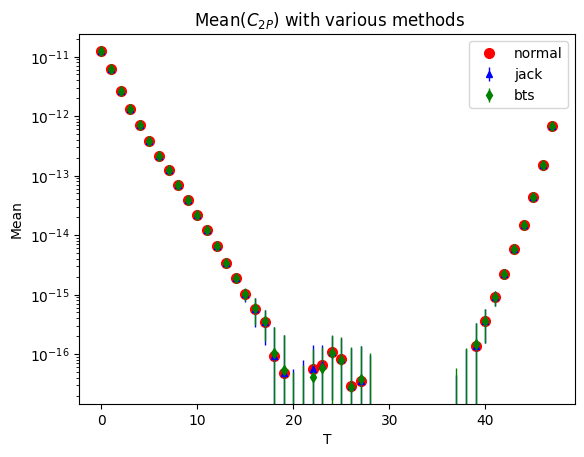

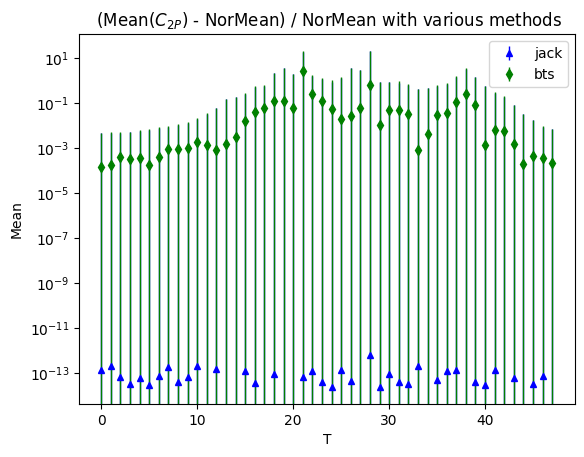

In [41]:
_ = plt.plot(np.arange(latticeT), mean_normal, 'o',label="normal", markersize=7.0, color='red')

_ = plt.errorbar(np.arange(latticeT), mean_jack, yerr=std_jack, marker='^', linewidth=0, elinewidth=1.0, markersize=5.0,  label="jack", color="blue")

_ = plt.errorbar(np.arange(latticeT), mean_boot, yerr=std_boot, marker= 'd', linewidth=0, elinewidth=1.0, markersize=5.0, label="bts", color="green")

_ = plt.legend()

_ = plt.title(r" Mean($C_{2P}$) with various methods")
_ = plt.xlabel("T")
_ = plt.ylabel("Mean")

plt.yscale("log")

plt.figure()

_ = plt.errorbar(np.arange(latticeT), np.abs( (mean_jack-mean_normal)/mean_normal), yerr=std_jack/np.abs(mean_normal), marker='^', linewidth=0, elinewidth=1.0, markersize=5.0,  label="jack", color="blue")

_ = plt.errorbar(np.arange(latticeT), np.abs( (mean_boot-mean_normal)/mean_normal), yerr=std_boot/np.abs(mean_normal), marker= 'd', linewidth=0, elinewidth=1.0, markersize=5.0, label="bts", color="green")

_ = plt.legend()

_ = plt.title(r" (Mean($C_{2P}$) - NorMean) / NorMean with various methods")
_ = plt.xlabel("T")
_ = plt.ylabel("Mean")

plt.yscale("log")

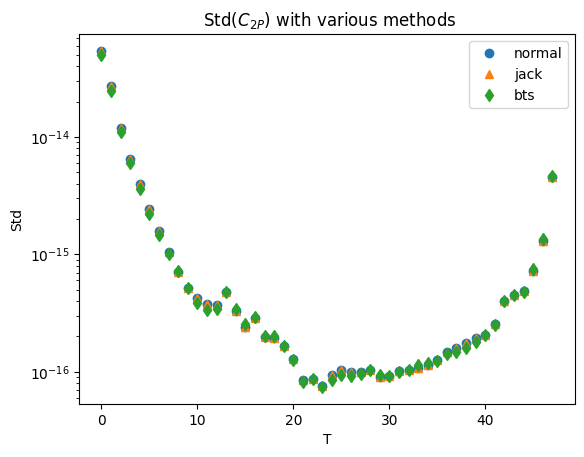

In [7]:
_ = plt.plot(np.arange(latticeT), std_normal, 'o',label="normal")

_ = plt.plot(np.arange(latticeT), std_jack, '^', label="jack")

_ = plt.plot(np.arange(latticeT), std_boot, 'd', label="bts")

_ = plt.legend()

_ = plt.title(r" Std($C_{2P}$) with various methods")
_ = plt.xlabel("T")
_ = plt.ylabel("Std")

plt.yscale("log")

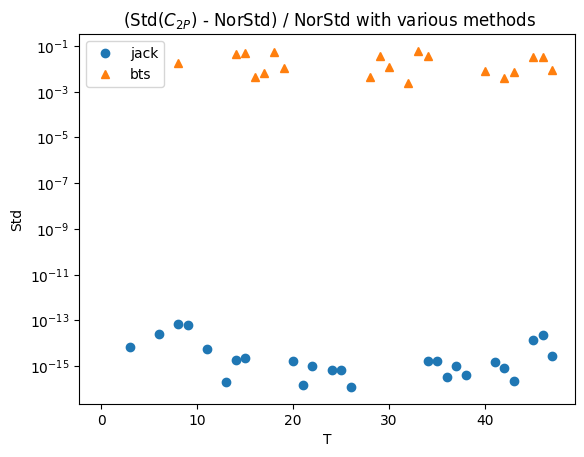

In [8]:
_ = plt.plot(np.arange(latticeT), (std_jack-std_normal)/std_normal, 'o',label="jack")

_ = plt.plot(np.arange(latticeT), (std_boot-std_normal)/std_normal, '^',label="bts")

_ = plt.legend()

_ = plt.title(r" (Std($C_{2P}$) - NorStd) / NorStd with various methods")
_ = plt.xlabel("T")
_ = plt.ylabel("Std")


plt.yscale("log")

In [35]:
mean_normal = np.mean(p2corr, axis=0)
std_normal = np.std(p2corr, axis=0, ddof=1) /np.sqrt(nconf)

mean_jack, std_jack, cov_jack = jackknife(p2corr, lambda x: np.std(x, axis=0)/np.sqrt(x.shape[0]), jack_axis_list=0, binsize=1, time_axis=-1)

#we choose Nres and sample_per_resample for the bootstrap as to match the jackknife ones
Nres=nconf
sample_per_resamples=nconf-1

mean_boot, std_boot, cov_boot = bootstrap(p2corr, lambda x: np.std(x, axis=0)/np.sqrt(x.shape[0]), bootstrap_axis_list=0, Nres=Nres, sample_per_resamples=sample_per_resamples, time_axis=-1)

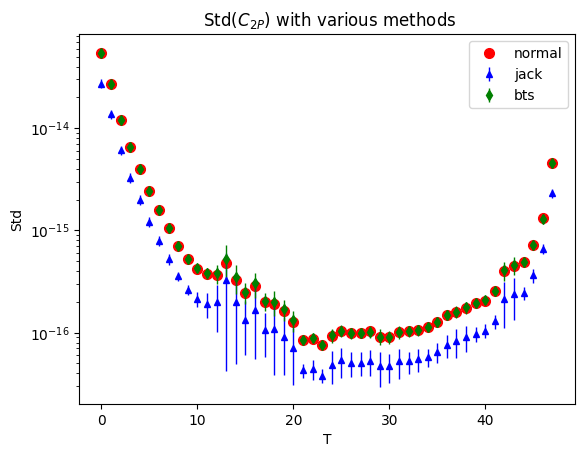

In [36]:
_ = plt.plot(np.arange(latticeT), std_normal, 'o',label="normal", markersize=7.0, color='red')

_ = plt.errorbar(np.arange(latticeT), mean_jack, yerr=std_jack, marker='^', linewidth=0, elinewidth=1.0, markersize=5.0,  label="jack", color="blue")

_ = plt.errorbar(np.arange(latticeT), mean_boot, yerr=std_boot, marker= 'd', linewidth=0, elinewidth=1.0, markersize=5.0, label="bts", color="green")

_ = plt.legend()

_ = plt.title(r" Std($C_{2P}$) with various methods")
_ = plt.xlabel("T")
_ = plt.ylabel("Std")

plt.yscale("log")

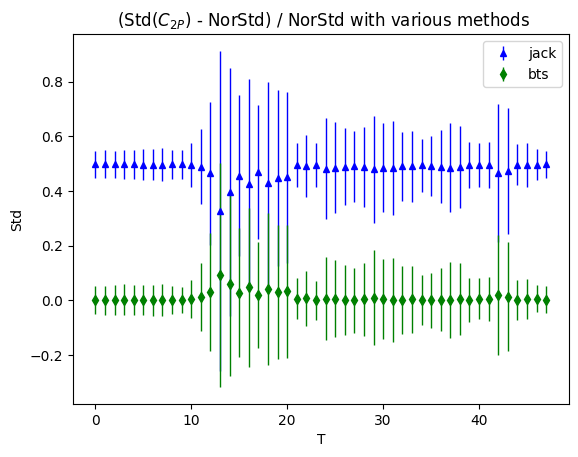

In [38]:
_ = plt.errorbar(np.arange(latticeT), np.abs(mean_jack-std_normal)/std_normal, yerr=std_jack/std_normal, marker='^', linewidth=0, elinewidth=1.0, markersize=5.0,  label="jack", color="blue")

_ = plt.errorbar(np.arange(latticeT), np.abs(mean_boot-std_normal)/std_normal, yerr=std_boot/std_normal, marker= 'd', linewidth=0, elinewidth=1.0, markersize=5.0, label="bts", color="green")

_ = plt.legend()

_ = plt.title(r" (Std($C_{2P}$) - NorStd) / NorStd with various methods")
_ = plt.xlabel("T")
_ = plt.ylabel("Std")

#plt.yscale("log")

# Small checks

In [25]:
Nres=150

p2corr_res = bootstrap_resamples(in_array_list=p2corr, observable= lambda x: x, bootstrap_axis_list=0, Nres=Nres, sample_per_resamples=20)

"(Nres, Nconf, latticeT)"
p2corr_res.shape

'(Nres, Nconf, latticeT)'

(150, 20, 48)

In [26]:
obs_total = np.mean(p2corr, axis=0)

obs_resamp = np.asarray( [ np.mean(p2,axis=0) for p2 in p2corr_res] )


boot_mean = np.mean(obs_resamp, axis=0)

bias = boot_mean-obs_total

bias / obs_total

array([ 2.51763331e-05,  2.70180441e-04,  2.17734076e-04,  2.78400894e-04,
        2.63545262e-04, -8.86514164e-04, -2.77306078e-03, -3.50723824e-03,
       -4.42848860e-03, -4.69666785e-03, -5.84490641e-03, -5.23901983e-04,
        1.25673776e-02,  3.73867500e-02,  3.33465104e-02,  4.83322037e-02,
        1.73085203e-01,  3.06447608e-01,  1.19389794e+00,  1.39683382e+00,
       -6.34496540e-01, -2.03224113e+00, -4.14655530e-01, -3.60739557e-01,
       -3.99072307e-01, -6.04732950e-01, -1.31250094e+00, -4.54250123e-01,
        3.10547471e-02,  6.93242436e-03, -2.99735975e-02, -5.81562621e-03,
       -1.80494585e-01, -3.60745668e-02,  4.87562834e-02, -2.39814754e-02,
       -3.47995092e-03,  1.39539337e-01,  4.43468920e-01,  2.11395799e-01,
        2.18213528e-01,  9.57181445e-02, -8.97384127e-03, -2.45735916e-02,
       -1.40462766e-02, -6.56635918e-03, -2.62644125e-03,  7.04661047e-04])

In [27]:
Nconf = 10
latT = 12

Nres = 6
Conf_per_Res = 8

ok = np.arange(1,Nconf*latT+1).reshape((Nconf,latT)) #say Nconf=10, latT=12
ok

selection = np.random.randint(0,Nconf, Conf_per_Res) #one selection = one resample
selection

np.take( ok ,indices=np.arange(ok.shape[0]), axis=1)[selection]

array([[  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12],
       [ 13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24],
       [ 25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36],
       [ 37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48],
       [ 49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60],
       [ 61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72],
       [ 73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84],
       [ 85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96],
       [ 97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108],
       [109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120]])

array([5, 1, 2, 6, 2, 2, 1, 0])

array([[61, 62, 63, 64, 65, 66, 67, 68, 69, 70],
       [13, 14, 15, 16, 17, 18, 19, 20, 21, 22],
       [25, 26, 27, 28, 29, 30, 31, 32, 33, 34],
       [73, 74, 75, 76, 77, 78, 79, 80, 81, 82],
       [25, 26, 27, 28, 29, 30, 31, 32, 33, 34],
       [25, 26, 27, 28, 29, 30, 31, 32, 33, 34],
       [13, 14, 15, 16, 17, 18, 19, 20, 21, 22],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])

In [28]:
Nconf = 10
latT = 12
Nop = 2

Nres = 3
Conf_per_Res = 8

conf_axis=1
ok = np.arange(1,Nconf*Nop*latT+1).reshape((Nop,Nconf,latT)) #say Nconf=10, latT=12
ok

selection = np.random.randint(0,Nconf, Conf_per_Res) #one selection = one resample
selection

#np.take( ok ,indices=np.arange(ok.shape[-1]), axis=-1)#[selection]
#np.take( ok ,indices=np.arange(ok.shape[0]), axis=-1)#[selection].shape
#ok[selection]
#ok[selection].shape

np.take(ok, indices = selection, axis=conf_axis)
np.take(ok, indices = selection, axis=conf_axis).shape

array([[[  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12],
        [ 13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24],
        [ 25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36],
        [ 37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48],
        [ 49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60],
        [ 61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72],
        [ 73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84],
        [ 85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96],
        [ 97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108],
        [109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120]],

       [[121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132],
        [133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144],
        [145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156],
        [157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168],
        [169, 170,

array([9, 1, 1, 8, 5, 6, 9, 6])

array([[[109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120],
        [ 13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24],
        [ 13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24],
        [ 97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108],
        [ 61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72],
        [ 73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84],
        [109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120],
        [ 73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84]],

       [[229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240],
        [133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144],
        [133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144],
        [217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228],
        [181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192],
        [193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204],
        [229, 230,

(2, 8, 12)

In [29]:
ok.shape[:1] + (8,) + ok.shape[1+1:] 

(2, 8, 12)

In [30]:
selection_list = [np.random.randint(0,Nconf, Conf_per_Res) for _ in range(Nres)]

selection_list

[array([7, 9, 3, 1, 1, 1, 1, 8]),
 array([4, 1, 9, 3, 5, 0, 7, 4]),
 array([2, 8, 0, 8, 3, 4, 5, 2])]

In [31]:
np.take(ok, indices = selection_list, axis=conf_axis).shape
np.moveaxis( np.take(ok, indices = selection_list, axis=conf_axis), source=conf_axis, destination=0).shape
np.moveaxis( np.take(ok, indices = selection_list, axis=conf_axis), source=conf_axis, destination=0)

(2, 3, 8, 12)

(3, 2, 8, 12)

array([[[[ 85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96],
         [109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120],
         [ 37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48],
         [ 13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24],
         [ 13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24],
         [ 13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24],
         [ 13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24],
         [ 97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108]],

        [[205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216],
         [229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240],
         [157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168],
         [133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144],
         [133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144],
         [133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144],
    

In [32]:
from utilities import bootstrap_resamples

In [33]:
Nconf=10
latT=12

Nres = 3
sampl_per_resample=9

ok = np.arange(1,Nconf*latT+1).reshape((Nconf,latT))
ok

array([[  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12],
       [ 13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24],
       [ 25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36],
       [ 37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48],
       [ 49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60],
       [ 61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72],
       [ 73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84],
       [ 85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96],
       [ 97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108],
       [109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120]])

In [34]:
resamp = bootstrap_resamples(in_array_list=ok, observable= lambda x: x-1, bootstrap_axis_list=0, Nres=Nres, sample_per_resamples=sampl_per_resample)

resamp.shape
resamp

(3, 9, 12)

array([[[ 96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107],
        [ 24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35],
        [ 36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47],
        [ 96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107],
        [ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95],
        [ 36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47],
        [ 72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83],
        [ 12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23],
        [  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11]],

       [[ 60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71],
        [ 72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83],
        [ 12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23],
        [ 12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23],
        [  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11],
        [ 12,  13,